<!-- Startup Sucess EDA -->

# StartUp Sucess- EDA

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline
from tabulate import tabulate
# !pip install folium
import folium
# %pip install yfinance
# %pip install tweepy
# %pip install wbdata pandas
import sys
sys.path.append('../src')

import yfinance as yf
import datetime
# import tweepy
import wbdata
from preprocess import preprocess_data_classifier, combine_rares_categories
from getdata import add_nasdaq_annual_changes, add_economic_indicators


# Explore and adjust data

In [2]:
# load data:
df = pd.read_csv('../data/startup_data.csv')
df.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    int64  
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   Unnamed: 6                430 non-null    object 
 8   name                      923 non-null    object 
 9   labels                    923 non-null    int64  
 10  founded_at                923 non-null    object 
 11  closed_at                 335 non-null    object 
 12  first_funding_at          923 non-null    object 
 13  last_funding_at           923 non-null    object 
 14  age_first_

In [4]:
columns_with_nan = df.columns[df.isna().any()].tolist()
print(columns_with_nan)

['Unnamed: 6', 'closed_at', 'age_first_milestone_year', 'age_last_milestone_year', 'state_code.1']


There are a few columns with missing values. 2 of them are - 'age_first_milestone_year', 'age_last_milestone_year'. The companies that have no value in those columns also have 0 in milestones column. So, in order to deal with the missing values, we used a correlation matrix and we discovered that age_last_funding_year column has the highest correlation with 'age_first_milestone_year' & 'age_last_milestone_year'. (It make sense since one the company's milestones coulld be raising certain amount of money which could be done by funding).



In [5]:
#let's look for correlations for those columns.

# Compute the correlation matrix
correlation_matrix = df.corr(numeric_only = True)

# Find correlations with the columns containing missing values
correlations_first_milestone_age = correlation_matrix['age_first_milestone_year'].abs().sort_values(ascending=False)
correlations_age_last_milestone_year = correlation_matrix['age_last_milestone_year'].abs().sort_values(ascending=False)

# Print the correlations
print(correlations_first_milestone_age[correlations_first_milestone_age>0.5])
print(correlations_age_last_milestone_year[correlations_age_last_milestone_year>0.5])

# We see that last_funding_age is highly correlated with our columns.
# It could make sense since it's reasonable that one of a company's milestones is to raise certin amount of money which could
# be done by funding. 

age_first_milestone_year    1.000000
age_last_milestone_year     0.777484
age_last_funding_year       0.687515
age_first_funding_year      0.593526
Name: age_first_milestone_year, dtype: float64
age_last_milestone_year     1.000000
age_first_milestone_year    0.777484
age_last_funding_year       0.632099
Name: age_last_milestone_year, dtype: float64


In order to fill in the missing values we used, in the preprocessing function, the knn imputer. We evaluated the effectiveness of the imputation process and assessed the quality of the imputed data by comparing summary statistics (e.g., mean, median, standard deviation) before and after the imputation. We saw that the results are very much alike. We will now show an example:

Before Imputation:

age_first_milestone_year  skewness: 0.9444676662984656
age_last_milestone_year  skewness: 0.711933787802145
+-------+--------------------------+-------------------------+
|       | age_first_milestone_year | age_last_milestone_year |
+-------+--------------------------+-------------------------+
| count |          771.0           |          771.0          |
| mean  |    3.055353047989624     |    4.754422568093385    |
|  std  |    2.9770571428977264    |    3.21210715620923     |
|  min  |         -14.1699         |         -7.0055         |
|  25%  |           1.0            |          2.411          |
|  50%  |          2.5205          |         4.4767          |
|  75%  |          4.6863          |         6.7534          |
|  max  |         24.6849          |         24.6849         |
+-------+--------------------------+-------------------------+


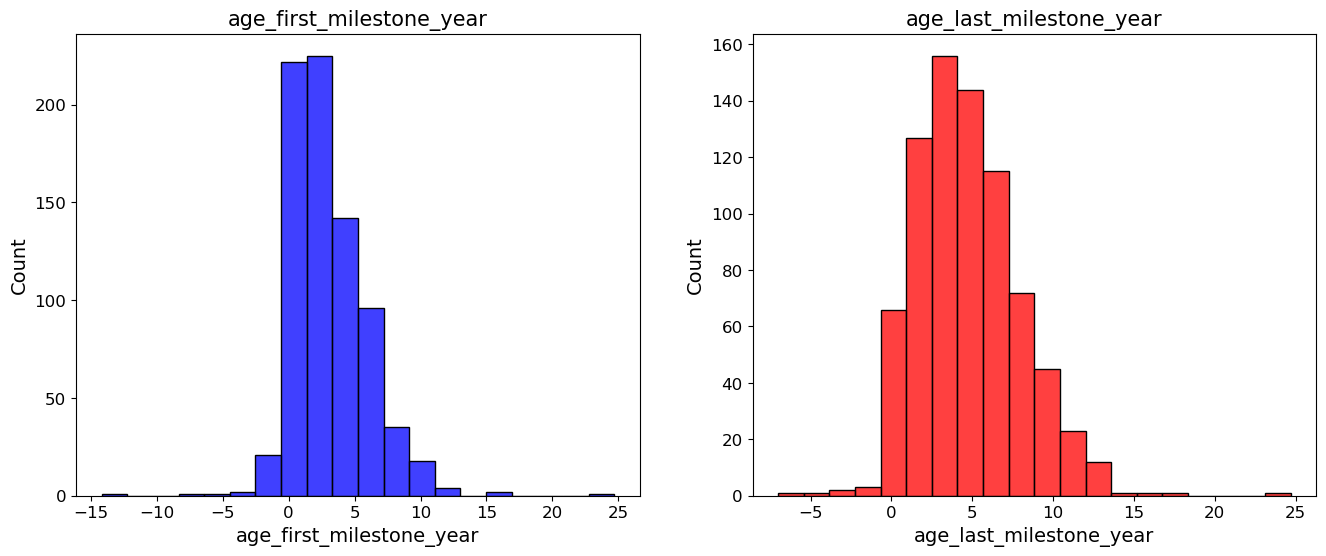

In [6]:
# looking at the columns with the missing values:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df['age_first_milestone_year'], bins=20, color='blue',ax=axes[0])
axes[0].set_title('age_first_milestone_year', fontsize=15)
axes[0].set_xlabel('age_first_milestone_year', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
plt.grid()
print('age_first_milestone_year', ' skewness:', df['age_first_milestone_year'].skew(axis = 0, skipna = True) )
df['age_first_milestone_year'].describe(include='all')

sns.histplot(data=df['age_last_milestone_year'],bins=20, color='red',ax=axes[1])
axes[1].set_title('age_last_milestone_year', fontsize=15)
axes[1].set_xlabel('age_last_milestone_year', fontsize=14)
axes[1].set_ylabel('Count', fontsize=14)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
plt.grid()
print('age_last_milestone_year', ' skewness:', df['age_last_milestone_year'].skew(axis = 0, skipna = True) )


# Get descriptive statistics
desc_first = df['age_first_milestone_year'].describe(include='all')
desc_last = df['age_last_milestone_year'].describe(include='all')

# Combine the statistics into a single DataFrame
desc_table = pd.DataFrame({
    'age_first_milestone_year': desc_first,
    'age_last_milestone_year': desc_last
})

# Display the table with tabulate
print(tabulate(desc_table, headers='keys', tablefmt='pretty'))


In [7]:
from sklearn.impute import KNNImputer

# fill in the missing values using knn:

# Create a copy of the DataFrame with only the columns of interest 
columns_with_missing_values = ['age_first_milestone_year','age_last_milestone_year']
columns_of_interest = ['age_last_funding_year'] + columns_with_missing_values
data_subset = df[columns_of_interest].copy()

# Instantiate the KNNImputer with the desired number of neighbors
knn_imputer = KNNImputer(n_neighbors=5) 

# Fit and transform the data
imputed_data = knn_imputer.fit_transform(data_subset)

# Replace the missing values in the original DataFrame with the imputed values
for i, col in enumerate(columns_with_missing_values):
    df[col] = imputed_data[:, i + 1]  

##### To evaluate the effectiveness of the imputation process and assess the quality of the imputed data, 
##### we are comparing summary statistics(e.g., mean, median, standard deviation) before (2 cells above) and after the
##### imputation (the next cell). We see that the results are very much alike.

After Imputation:

age_first_milestone_year  skewness: 0.914178490254363
age_last_milestone_year  skewness: 0.678901901448389
+-------+--------------------------+-------------------------+
|       | age_first_milestone_year | age_last_milestone_year |
+-------+--------------------------+-------------------------+
| count |          923.0           |          923.0          |
| mean  |    3.1233303141928492    |    4.816485417118093    |
|  std  |    2.884283420125913     |   3.0952460377771205    |
|  min  |         -14.1699         |         -7.0055         |
|  25%  |          1.0027          |         2.60053         |
|  50%  |          2.7479          |         4.57534         |
|  75%  |          4.7589          |         6.75617         |
|  max  |         24.6849          |         24.6849         |
+-------+--------------------------+-------------------------+


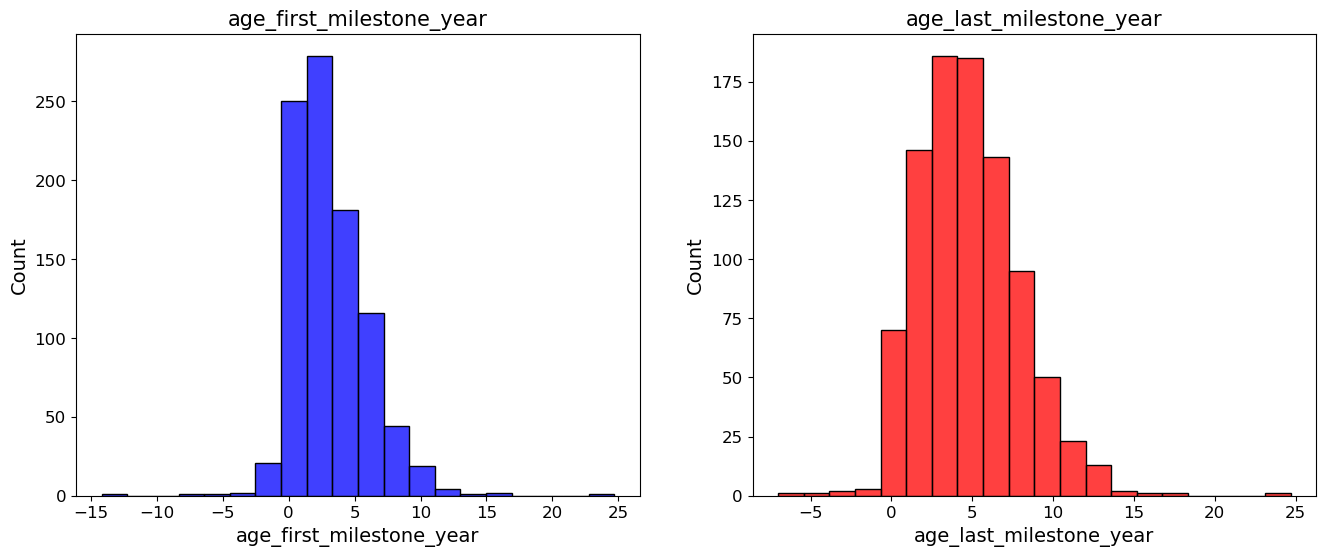

In [8]:
# looking at the columns with the missing values:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df['age_first_milestone_year'], bins=20, color='blue',ax=axes[0])
axes[0].set_title('age_first_milestone_year', fontsize=15)
axes[0].set_xlabel('age_first_milestone_year', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
plt.grid()
print('age_first_milestone_year', ' skewness:', df['age_first_milestone_year'].skew(axis = 0, skipna = True) )
df['age_first_milestone_year'].describe(include='all')

sns.histplot(data=df['age_last_milestone_year'],bins=20, color='red',ax=axes[1])
axes[1].set_title('age_last_milestone_year', fontsize=15)
axes[1].set_xlabel('age_last_milestone_year', fontsize=14)
axes[1].set_ylabel('Count', fontsize=14)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
plt.grid()
print('age_last_milestone_year', ' skewness:', df['age_last_milestone_year'].skew(axis = 0, skipna = True) )


# Get descriptive statistics
desc_first = df['age_first_milestone_year'].describe(include='all')
desc_last = df['age_last_milestone_year'].describe(include='all')

# Combine the statistics into a single DataFrame
desc_table = pd.DataFrame({
    'age_first_milestone_year': desc_first,
    'age_last_milestone_year': desc_last
})

# Display the table with tabulate
print(tabulate(desc_table, headers='keys', tablefmt='pretty'))


## Exploering some more interesting features:

### In the following graphs we see some outliers

relationships — Number of relationships a startup has. For example, a startup can have relationships with accountants, investors, vendors, mentors, etc.

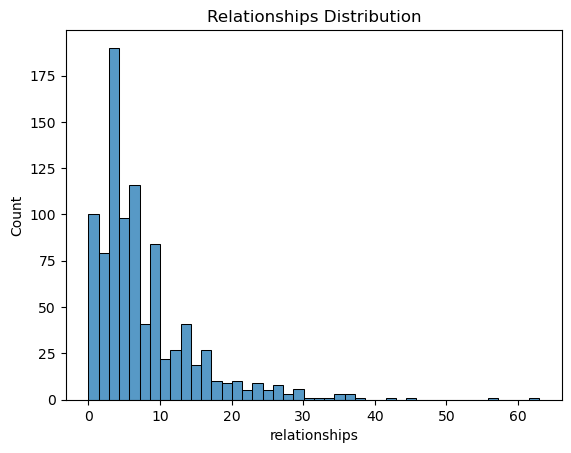

In [9]:
sns.histplot(df['relationships'])
plt.title('Relationships Distribution')
plt.show()

funding_total_usd - the amount of money the company got in funding

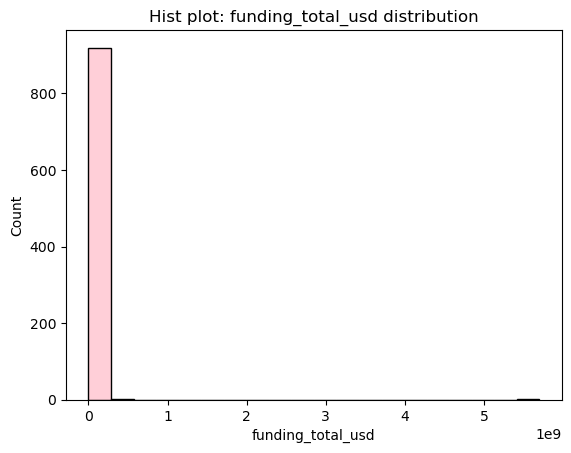

In [10]:
sns.histplot(df['funding_total_usd'],bins=20, color='pink')
plt.title('Hist plot: funding_total_usd distribution')
plt.show()

Text(0, 0.5, 'Funding Total (USD)')

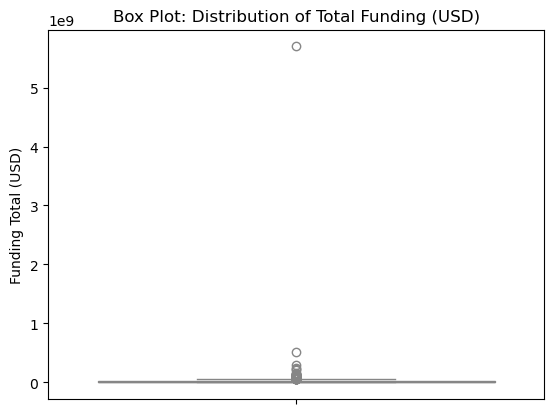

In [11]:
sns.boxplot(y="funding_total_usd", data=df, color='pink')
plt.title("Box Plot: Distribution of Total Funding (USD)")
plt.ylabel("Funding Total (USD)")

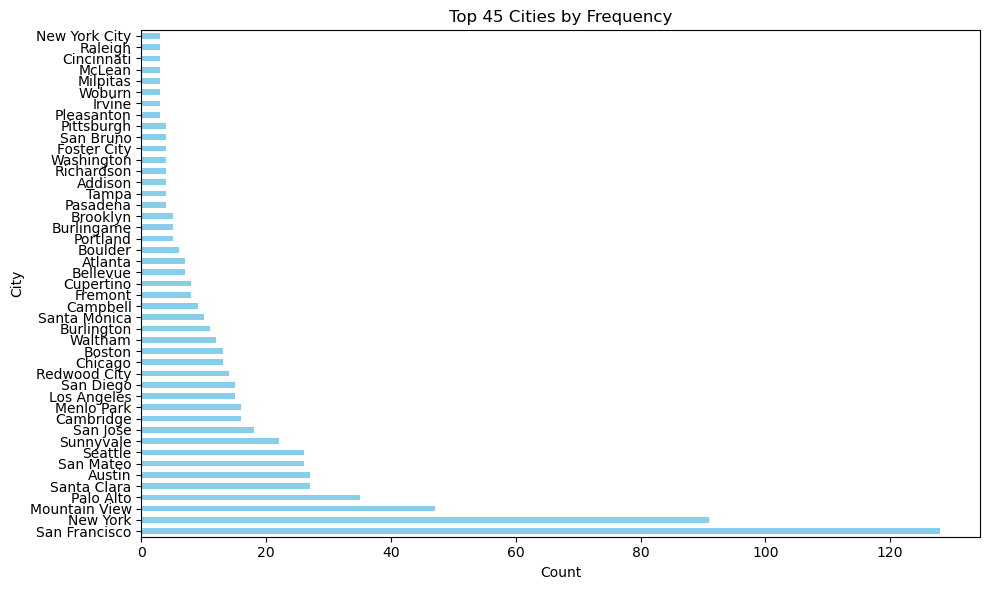

In [12]:
city_counts = df['city'].value_counts()
top_cities = city_counts.head(45)

# Plotting the top cities
plt.figure(figsize=(10, 6))
top_cities.plot(kind='barh', color='skyblue')
plt.title('Top 45 Cities by Frequency')
plt.xlabel('Count')
plt.ylabel('City')
plt.tight_layout()
plt.show()


We Created a folium map – a geographic interface – where we can see all the companies around the world, and we color coded it so that the successful companies are green colored, and the unsuccessful companies are red colored.


In [13]:
# Create a folium map centered on the first location in the dataframe
map = folium.Map(location=[df['latitude'][0], df['longitude'][0]], zoom_start=5)

for i in range(len(df)):
    popup_text = f"{df['status'][i]} "
    if df['status'][i] == 'acquired':
        c = 'green'
    else:# status = closed
        c = 'red'

    folium.Marker([df['latitude'][i], df['longitude'][i]],
        icon=folium.Icon(color=c,popup = popup_text), icon_size=(70, 70)).add_to(map)
    
# Display the map
map


We used cross-tabulation (crosstab) table to show that most of the companies are in CA and 2/3 of them were successful. So, it might be an indication that there's a strong connection between the companies location and their chance to succeed. We then show a similar connection using in_Top500 column.

In [14]:
# cross-tabulation (crosstab) table
ct = pd.crosstab(index=df['status'], columns=[df['is_NY'],df['is_MA'], df['is_CA'], df['is_TX'],df['is_otherstate']])
ct

is_NY          0                     1
is_MA          0                 1   0
is_CA          0             1   0   0
is_TX          0        1    0   0   0
is_otherstate  0    1   0    0   0   0
status                                
acquired       0  101  23  332  64  77
closed         1  103  19  155  19  29

In [15]:
# cross-tabulation (crosstab) table
ct = pd.crosstab(index=df['status'], columns=[df['is_top500']])
ct

is_top500,0,1
status,,
acquired,60,537
closed,116,210


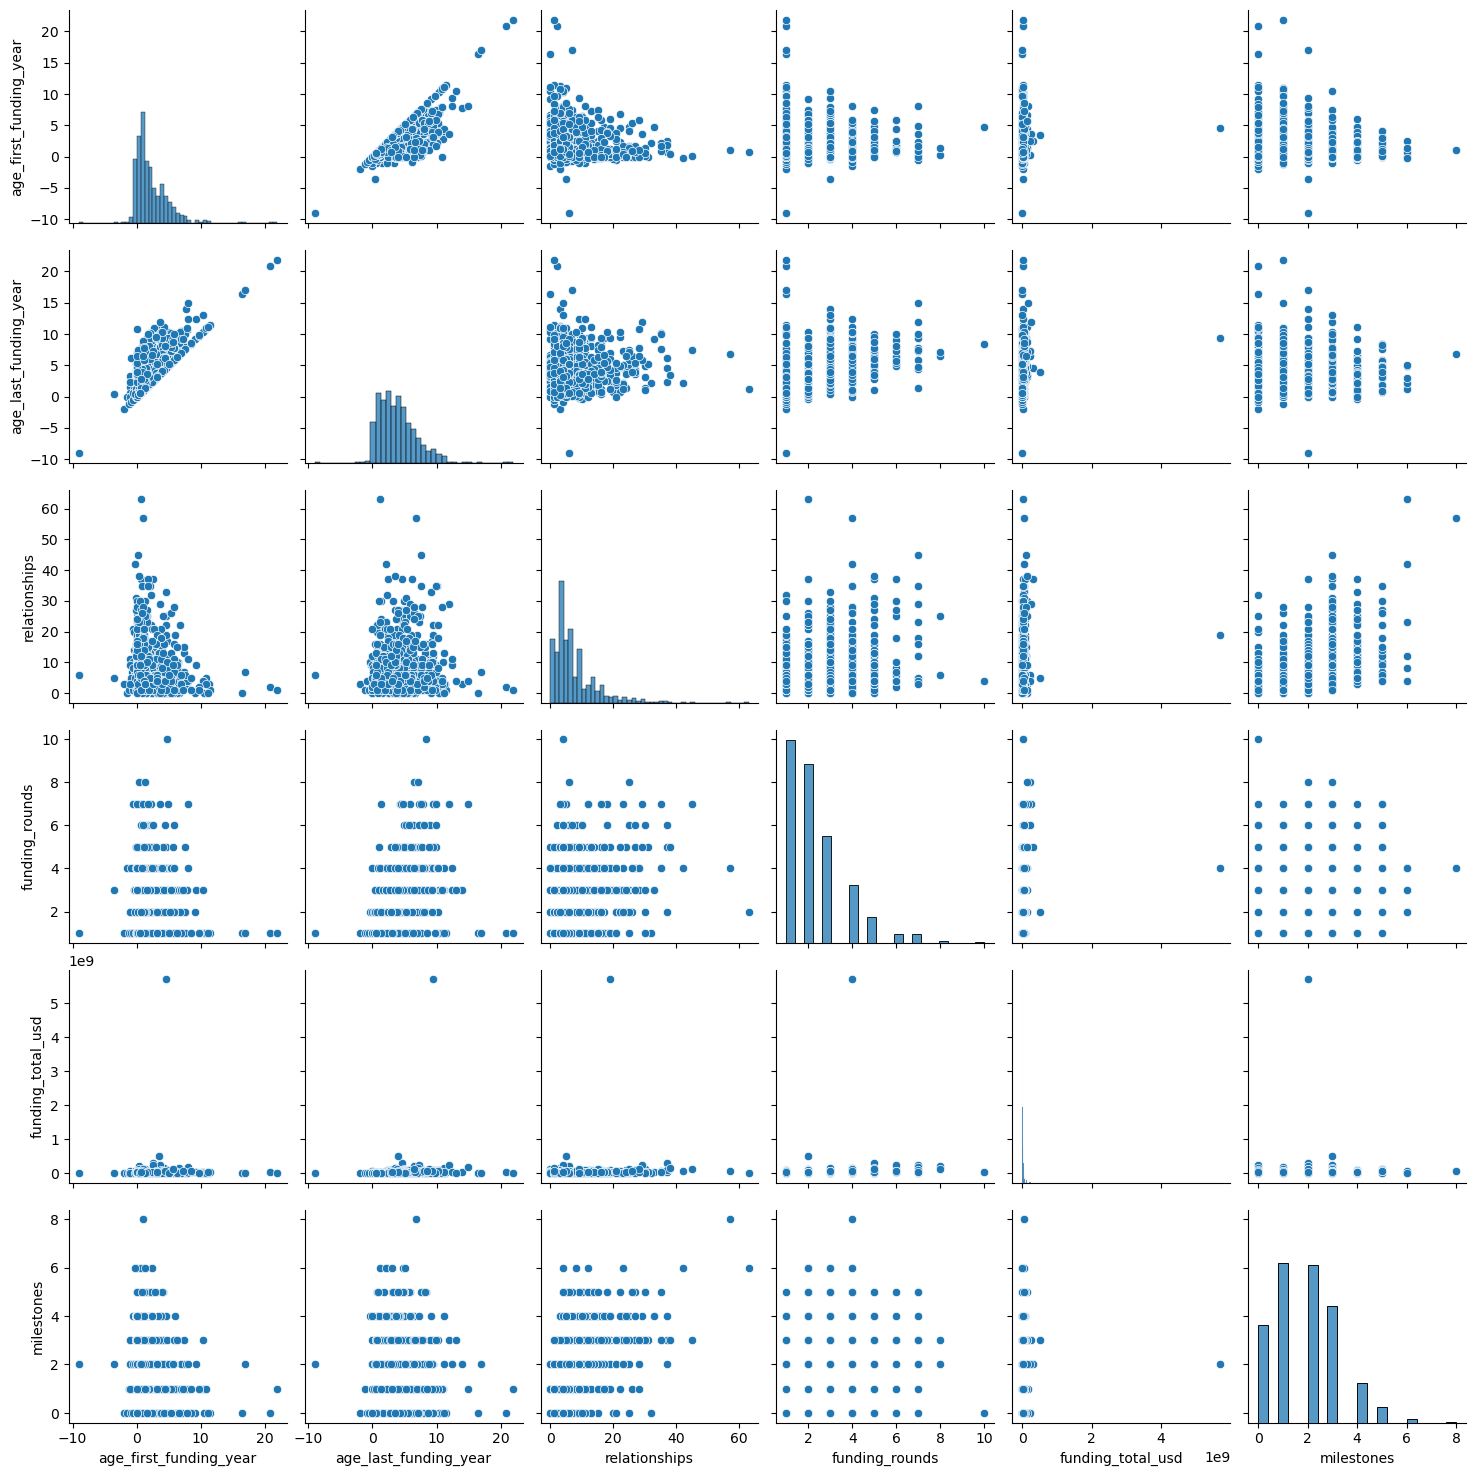

In [16]:
# Pair plot
sns.pairplot(df[['age_first_funding_year', 'age_last_funding_year', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones']])
plt.show()


/tmp/ipykernel_150325/2808052165.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status', data=df, palette='viridis')


Text(0.5, 1.0, 'Distribution of Startup Status')

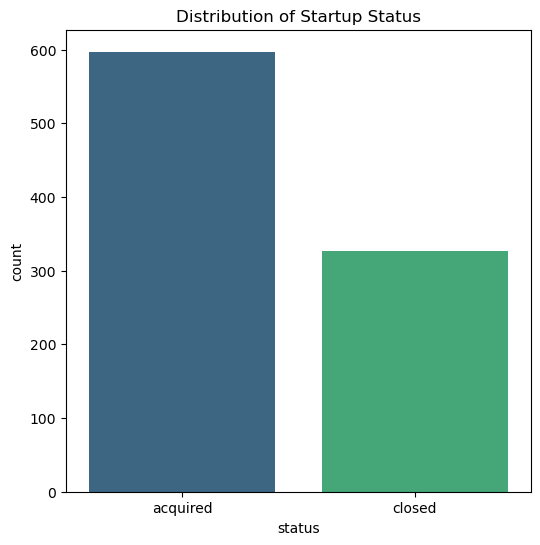

In [17]:
# Distribution of status
plt.figure(figsize=(6, 6))
sns.countplot(x='status', data=df, palette='viridis')
plt.title('Distribution of Startup Status')


/tmp/ipykernel_150325/3078408039.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='status', y='funding_rounds', data=df, palette='viridis')


Text(0.5, 1.0, 'Funding Rounds Distribution by Status')

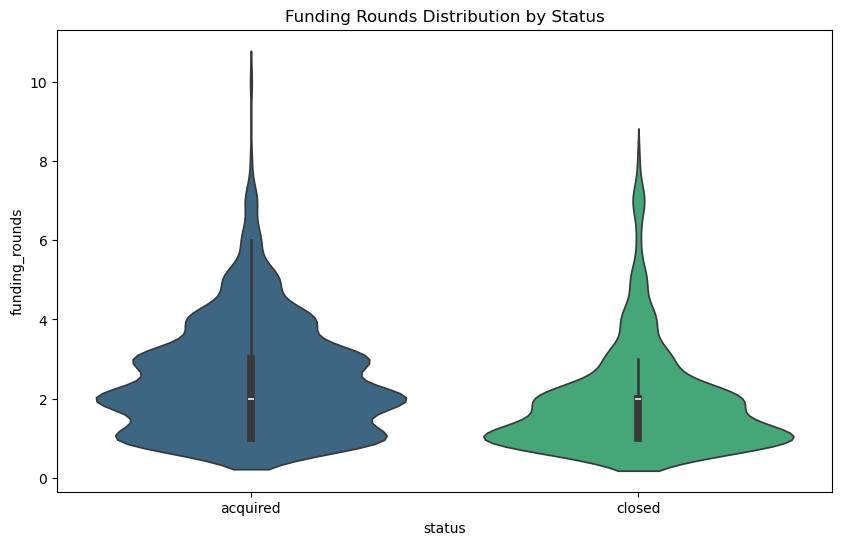

In [18]:
# Violin plot for funding rounds distribution by status
plt.figure(figsize=(10, 6))
sns.violinplot(x='status', y='funding_rounds', data=df, palette='viridis')
plt.title('Funding Rounds Distribution by Status')


/tmp/ipykernel_150325/3783845404.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y='relationships', data=df, palette='coolwarm')


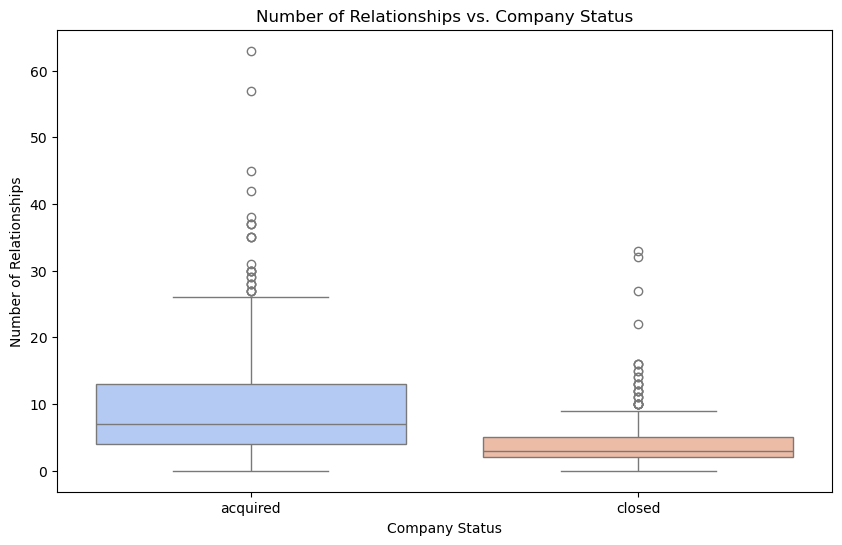

In [19]:
plt.figure(figsize=(10, 6))

# Create a box plot to show the distribution of relationships for each status
sns.boxplot(x='status', y='relationships', data=df, palette='coolwarm')

# Set the title and labels
plt.title('Number of Relationships vs. Company Status')
plt.xlabel('Company Status')
plt.ylabel('Number of Relationships')

plt.show()


/tmp/ipykernel_150325/1619564235.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=funding_bin_counts.index, y=funding_bin_counts.values, palette='viridis')


Text(0, 0.5, 'Number of Startups')

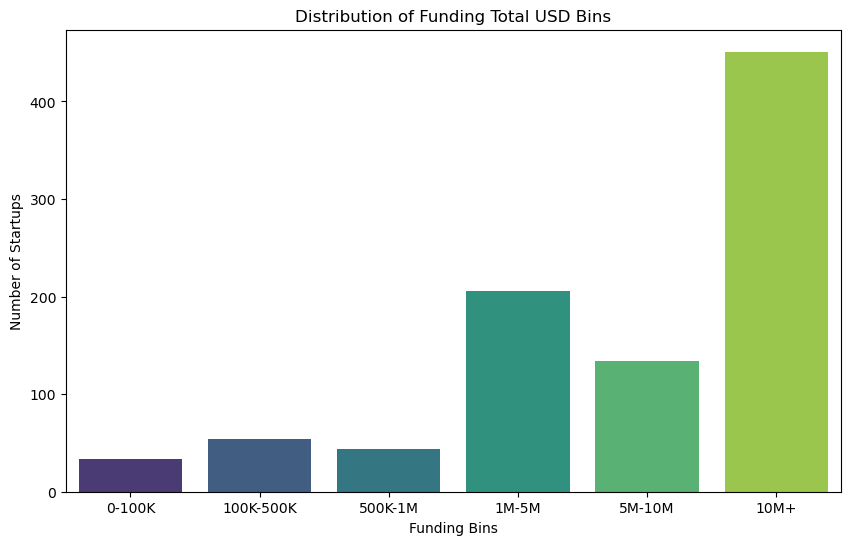

In [20]:
# plot funding bins using a bar plot
bin_edges = [0, 100000, 500000, 1000000, 5000000, 10000000, df['funding_total_usd'].max()] # binning funding_total_usd- i use this since histplot was unclear
bin_labels = ['0-100K', '100K-500K', '500K-1M', '1M-5M', '5M-10M', '10M+']
df['funding_bins'] = pd.cut(df['funding_total_usd'], bins=bin_edges, labels=bin_labels, include_lowest=True)

funding_bin_counts = df['funding_bins'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=funding_bin_counts.index, y=funding_bin_counts.values, palette='viridis')
plt.title('Distribution of Funding Total USD Bins')
plt.xlabel('Funding Bins')
plt.ylabel('Number of Startups')


So, we've seen that there are a few things that needs to be done in the preprocessing:
1. Missing values handling
2. Outliers handling
3. Adjusting dates format
4. Drop unnecessary features

In [21]:
# Add economic indicators
df = add_nasdaq_annual_changes(df)
indicator_code = 'NY.GDP.MKTP.KD.ZG'
df = add_economic_indicators(df, indicator_code)
indicator_code = 'SL.UEM.TOTL.ZS'
df = add_economic_indicators(df, indicator_code)

[*********************100%%**********************]  1 of 1 completed


/tmp/ipykernel_150325/1496625562.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y='avg_participants', data=df, palette='coolwarm')


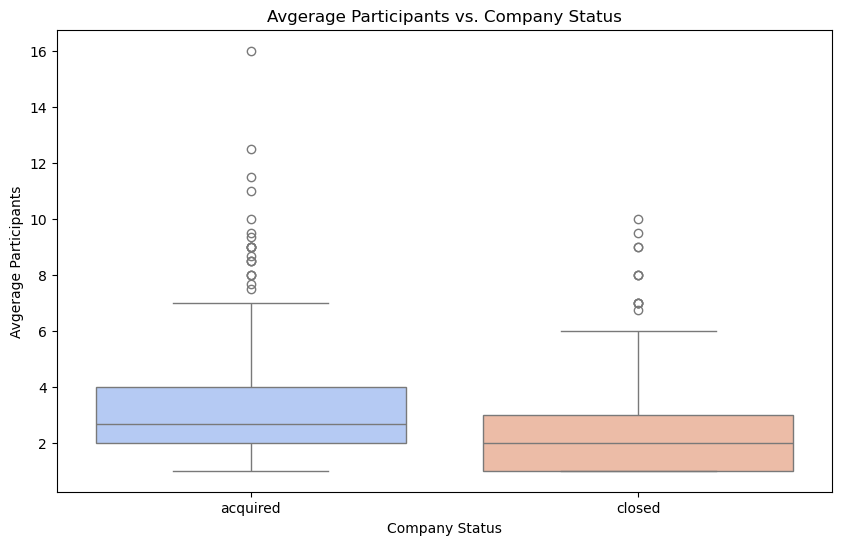

In [22]:
plt.figure(figsize=(10, 6))

# Create a box plot to show the distribution of relationships for each status
sns.boxplot(x='status', y='avg_participants', data=df, palette='coolwarm')

# Set the title and labels
plt.title('Avgerage Participants vs. Company Status')
plt.xlabel('Company Status')
plt.ylabel('Avgerage Participants')

plt.show()

# Preprocessing 

In [23]:
# Count all occurrences of each city
df_processed_cities = combine_rares_categories(df, column='city', threshold=3)
df_processed_cities['city'].value_counts()

rare_count = df_processed_cities['city'].value_counts().get('Rare', 0)
print(f"Count of 'Rare': {rare_count}")

total_count = df_processed_cities['city'].count()
print(f"Total count: {total_count}")

Count of 'Rare': 192
Total count: 923


In [24]:
df_cleaned, xx = preprocess_data_classifier(df, useKNNImputer=False, remove_feature_names=False)

In [25]:
df_cleaned.head()

,0,1,2,3,4,5,6,7,8,9,...,UEM_growth_at_year_7,UEM_growth_at_year_8,UEM_growth_at_year_9,UEM_growth_at_year_10,first_funding_at_year,first_funding_at_month,first_funding_at_day,last_funding_at_year,last_funding_at_month,last_funding_at_day
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.346899,-1.064648,-0.831382,-4.140205e-01,0.655214,-0.579983,-0.926741,0.395267,-1.462555,-1.249880
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.951666,2.242322,1.455530,1.743663e-16,-1.097192,-1.134509,0.377734,-0.065793,1.669152,1.510941
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.684645,-0.548595,-1.349909,-1.169964e+00,1.093315,-0.857246,1.983242,0.395267,-0.893154,1.715446
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.533782,0.850391,1.555439,2.005773e+00,-1.097192,-1.134509,0.678767,-0.987913,-0.608453,1.204183
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.918313,0.511732,-0.611583,-1.389681e+00,1.093315,0.529069,-0.926741,1.317387,-0.608453,-1.249880


In [26]:
# sns.histplot(df_cleaned['funding_total_usd_log'],bins=20, color='pink')
# plt.title('Hist plot: funding_total_usd distribution log')
# plt.show()

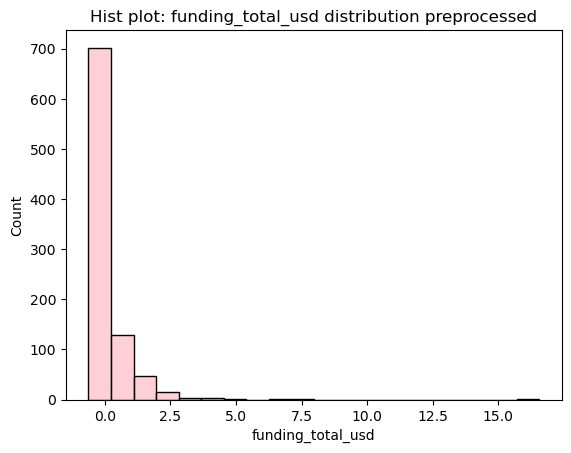

In [27]:
sns.histplot(df_cleaned['funding_total_usd'],bins=20, color='pink')
plt.title('Hist plot: funding_total_usd distribution preprocessed')
plt.show()


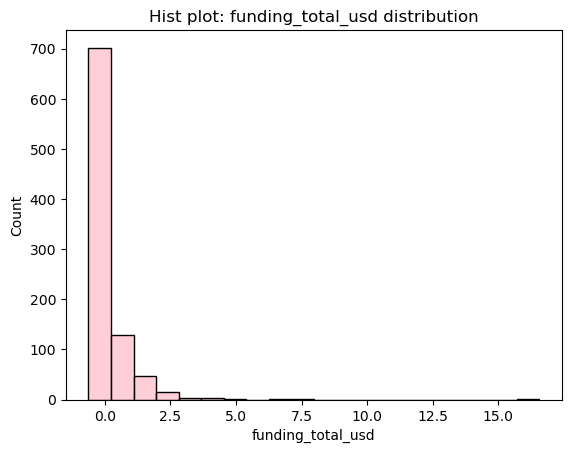

In [28]:
sns.histplot(df_cleaned['funding_total_usd'],bins=20, color='pink')
plt.title('Hist plot: funding_total_usd distribution')
plt.show()

In [29]:
df_cleaned.isnull().sum().sum() # no null values


0

In [30]:
df_cleaned.head()

,0,1,2,3,4,5,6,7,8,9,...,UEM_growth_at_year_7,UEM_growth_at_year_8,UEM_growth_at_year_9,UEM_growth_at_year_10,first_funding_at_year,first_funding_at_month,first_funding_at_day,last_funding_at_year,last_funding_at_month,last_funding_at_day
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.346899,-1.064648,-0.831382,-4.140205e-01,0.655214,-0.579983,-0.926741,0.395267,-1.462555,-1.249880
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.951666,2.242322,1.455530,1.743663e-16,-1.097192,-1.134509,0.377734,-0.065793,1.669152,1.510941
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.684645,-0.548595,-1.349909,-1.169964e+00,1.093315,-0.857246,1.983242,0.395267,-0.893154,1.715446
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.533782,0.850391,1.555439,2.005773e+00,-1.097192,-1.134509,0.678767,-0.987913,-0.608453,1.204183
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.918313,0.511732,-0.611583,-1.389681e+00,1.093315,0.529069,-0.926741,1.317387,-0.608453,-1.249880


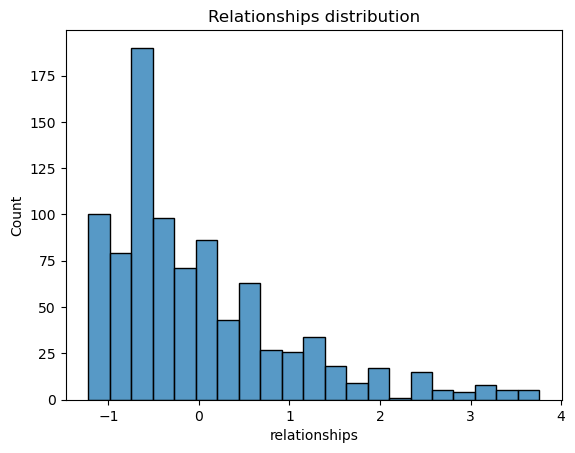

In [31]:
sns.histplot(df_cleaned['relationships'])
plt.title('Relationships distribution')
plt.show()

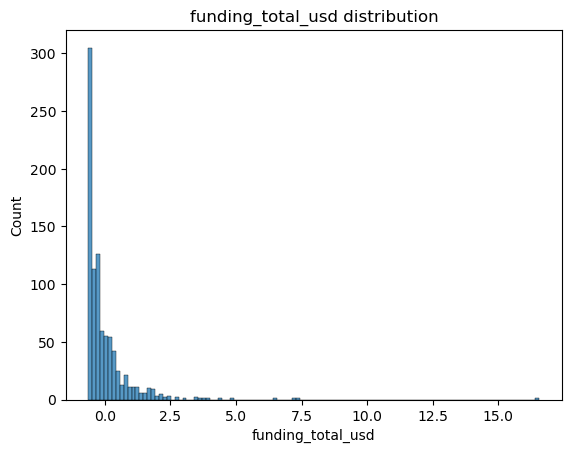

In [32]:
sns.histplot(df_cleaned['funding_total_usd'])
plt.title('funding_total_usd distribution')
plt.show()

<Axes: ylabel='funding_total_usd'>

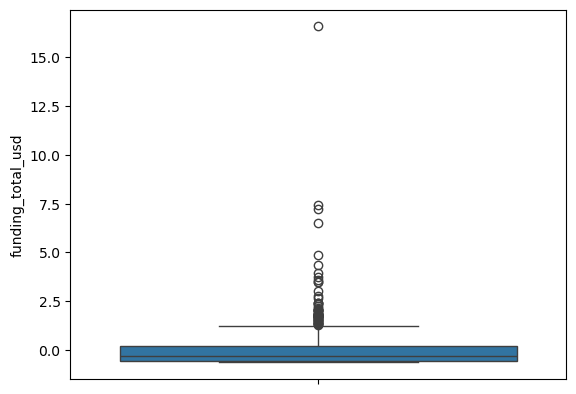

In [33]:
sns.boxplot(y="funding_total_usd", data=df_cleaned)

In [34]:
# df.to_csv('df.csv', index=False)
